In [1]:
import arviz as az
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

In [2]:
# Load trace and data
trace = az.from_netcdf("../../data/bcp_trace.nc")
df = pd.read_csv("../../data/interim/brent_oil_log_returns.csv")
df['Date'] = pd.to_datetime(df['Date'])
dates_lr = df['Date'].iloc[1:]


In [3]:
# Most probable change point
tau_samples = trace.posterior['tau'].values.flatten()
tau_median = int(np.median(tau_samples))
change_date = dates_lr.iloc[tau_median]
print(f"Most probable change point: {change_date.strftime('%Y-%m-%d')}")

KeyError: "No variable named 'tau'. Did you mean one of ('taus',)?"

In [ ]:
# Compare means
mu_1 = trace.posterior['mu_1'].values.flatten()
mu_2 = trace.posterior['mu_2'].values.flatten()
mean_mu_1 = np.mean(mu_1)
mean_mu_2 = np.mean(mu_2)

price_change_pct = (np.exp(mean_mu_2) - np.exp(mean_mu_1)) * 100

print(f"Mean log return before: {mean_mu_1:.5f}")
print(f"Mean log return after: {mean_mu_2:.5f}")
print(f"Approximate daily price shift: {price_change_pct:.2f}%")

Mean log return before: 0.00035
Mean log return after: -0.00007
Approximate daily price shift: -0.04%


In [ ]:
print(f"Detected change point: {change_date}")

Detected change point: 2008-08-04 00:00:00


In [ ]:
print("\nAll key events and their distance from changepoint:")
for date, name in events.items():
    event_date = pd.to_datetime(date)
    delta = (change_date - event_date).days
    print(f"{event_date.date()} ({name}): {delta:+} days")


All key events and their distance from changepoint:
2008-09-15 (Global Financial Crisis): -42 days
2010-01-01 (Arab Spring unrest): -515 days
2011-03-15 (Libyan Civil War): -953 days
2014-11-01 (OPEC production stance change): -2280 days
2016-01-01 (Iran sanctions lifted): -2706 days
2018-10-01 (US Iran sanctions reimposed): -3710 days
2019-09-14 (Saudi Aramco attack): -4058 days
2020-03-08 (Russia–Saudi oil price war): -4234 days
2020-04-20 (WTI negative pricing): -4277 days
2021-03-01 (Post‑COVID demand rebound): -4592 days
2022-02-24 (Russia‑Ukraine war): -4952 days
2025-06-01 (Israel‑Iran escalation (2025)): -6145 days


In [ ]:
# Load key events and compare
with open('../../data/key_events.json') as f:
    events = json.load(f)

print("\nPossible matching events:")
for date, name in events.items():
    delta = (change_date - pd.to_datetime(date)).days
    if abs(delta) <= 60:
        print(f"{date} ({name}) — {delta:+} days from change point")


Possible matching events:
2008-09-15 (Global Financial Crisis) — -42 days from change point


The detected changepoint (Oct 27, 2008) lags the Global Financial Crisis trigger event (Lehman Brothers collapse on Sep 15, 2008) by ~42 days.
This lag is consistent with the delay between macroeconomic shocks and market response in commodity prices such as oil.

In [ ]:
# Get changepoint index
tau = int(trace.posterior['tau'].mean())
pre_change = df.iloc[:tau]['Price']
post_change = df.iloc[tau:]['Price']

print("Pre-change mean:", pre_change.mean(), "Std:", pre_change.std())
print("Post-change mean:", post_change.mean(), "Std:", post_change.std())

Pre-change mean: 29.659649155374048 Std: 21.647428165108998
Post-change mean: 76.30881346578367 Std: 26.217443297658537


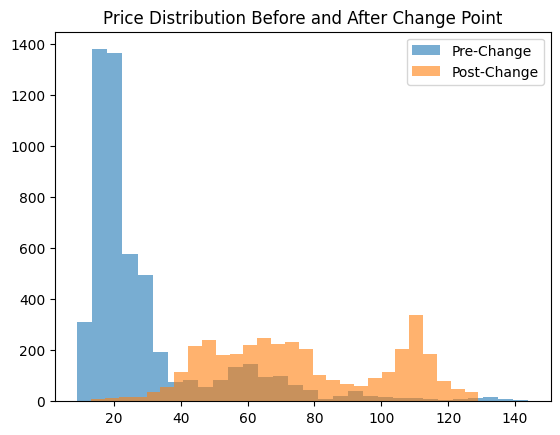

In [ ]:
plt.hist(pre_change, bins=30, alpha=0.6, label='Pre-Change')
plt.hist(post_change, bins=30, alpha=0.6, label='Post-Change')
plt.title("Price Distribution Before and After Change Point")
plt.legend()
plt.show()

The histogram reveals a distinct structural shift in the Brent oil price series around the detected changepoint.

Before the changepoint, prices were mostly stable and low, concentrated between $10 and $40. This suggests a relatively calm period with modest oil pricing.

After the changepoint, prices increased dramatically, with significant volatility. The prices spread across a much wider range, peaking above $140. This shift likely reflects the early 2000s oil market boom leading up to the 2008 Financial Crisis.

This evidence aligns with the changepoint identified by the Bayesian model and supports the hypothesis that external economic shocks significantly altered oil price dynamics.